In [24]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
import nltk
import pandas as pd
nltk.download('punkt')
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [439]:
import os
rootdir = '/home/stephane/automatic-data-generation/automatic_data_generation/'
dataroot= rootdir + 'data/'
os.chdir(rootdir)

# Exploring the vocabulary

In [433]:
from models.embedding import Datasets
datasets = Datasets(train_path=dataroot+'snips/train.csv', valid_path=dataroot+'snips/validate.csv', emb_dim=50, tokenizer='nltk')
vocab = datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

PermissionError: [Errno 13] Permission denied: '.vector_cache'

In [27]:
i2w[:20]

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'the',
 'a',
 'to',
 '_object_type_',
 'for',
 '_object_name_',
 'in',
 '_playlist_',
 'i',
 'at',
 '_timerange_',
 '_rating_value_',
 '_artist_',
 'play',
 '_music_item_',
 'of']

In [432]:
i2int

NameError: name 'i2int' is not defined

In [39]:
def word2idx(sentences, w2i):

    idx = [[] for i in range(len(sentences))]

    for i, sent in enumerate(sentences):

        for token in sent:
            idx[i].append(w2i[token])

    return idx

# Karpathy CharRNN

### Temperature: 0.2

I want to book a reservation for a restaurant for a party of a party of 6 points

I want to book a reservation for a restaurant for a restaurant for a restaurant in Barken Marcha at a party of 6

I need a table for a restaurant for a party of a party of 6 points

### Temperature: 0.5
I need a table for a reservation for a restaurant in the area that serves find movement in the area at a party of a siming from now

I want to half album to Musaf Rock Story Barb playlist.

I want to give this current book The Very Satarora for the twenty-textbook.

### Temperature: 1.0
What will the weather be syar llind in Playlin Man.

Tell it i from the Shawnua Tf Hiss Morny Cimes

Hadon in a top-fight?

play the song from the fifties for ten in Mondital Maker

# Analyzing the runs

In [178]:
def anneal_fn(anneal_function, step, k, x, m):
    if anneal_function == 'logistic':
        return m*float(1/(1+np.exp(-k*(step-x))))
    elif anneal_function == 'linear':
        return m*min(1, step/x)
anneal_fn = np.vectorize(anneal_fn)

In [179]:
import torch
run = torch.load('run.pkl')

## Dynamics

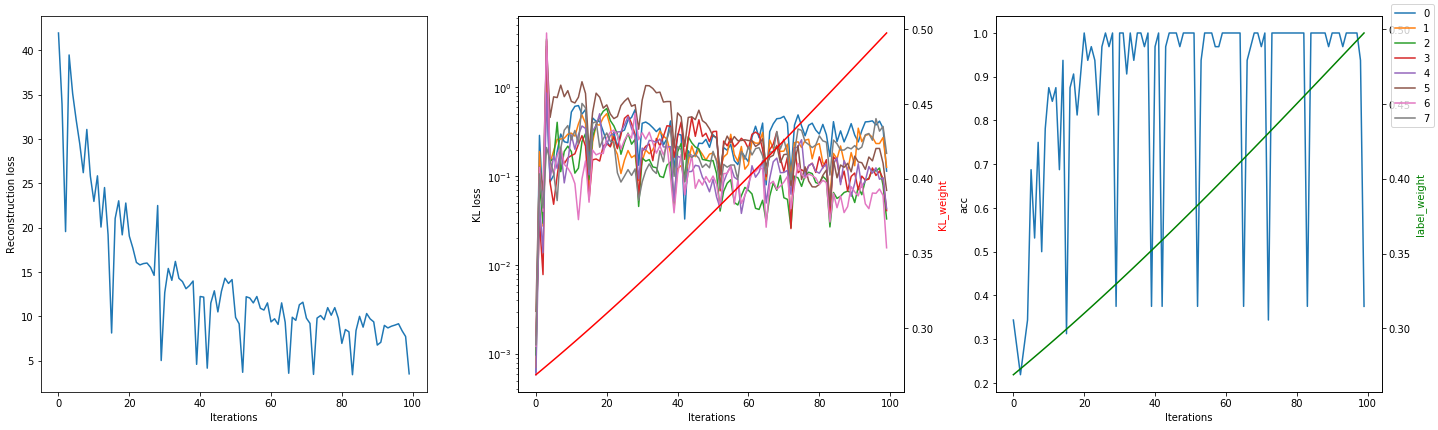

In [456]:
fig, axarr = plt.subplots(1,3, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['NLL_hist']
KL_hist  = run['KL_hist' ]
NMI_hist = run['NMI_hist']
acc_hist = run['acc_hist']
t = np.array(range(len(NLL_hist)))

KL_weight = anneal_fn(args.anneal_function, t, args.k1, args.x1, args.m1)
label_weight = anneal_fn(args.anneal_function, t, args.k2, args.x2, args.m2)

KL_hist = np.array(KL_hist)
axarr[0].plot(t, NLL_hist )
for i in range(args.latent_size):
    axarr[1].semilogy(t, KL_hist[:,i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')

fig.legend()
fig.tight_layout()
plt.show()

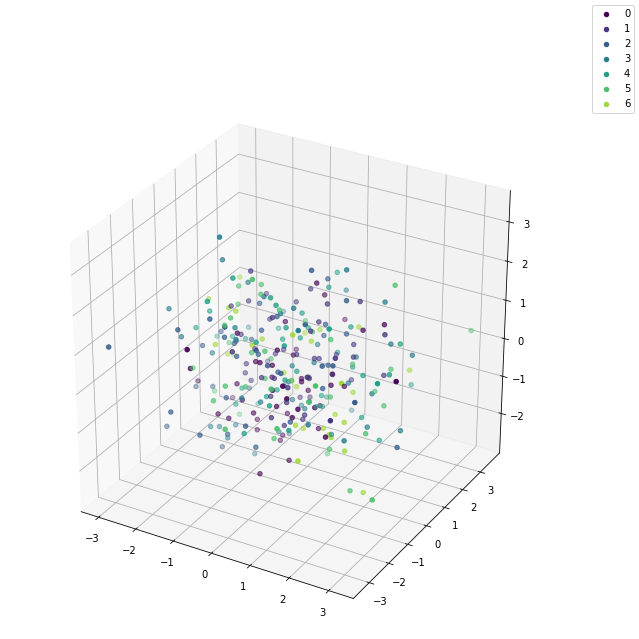

In [457]:
n_per_intent = 2000

latent = run['latent']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

## Embeddings

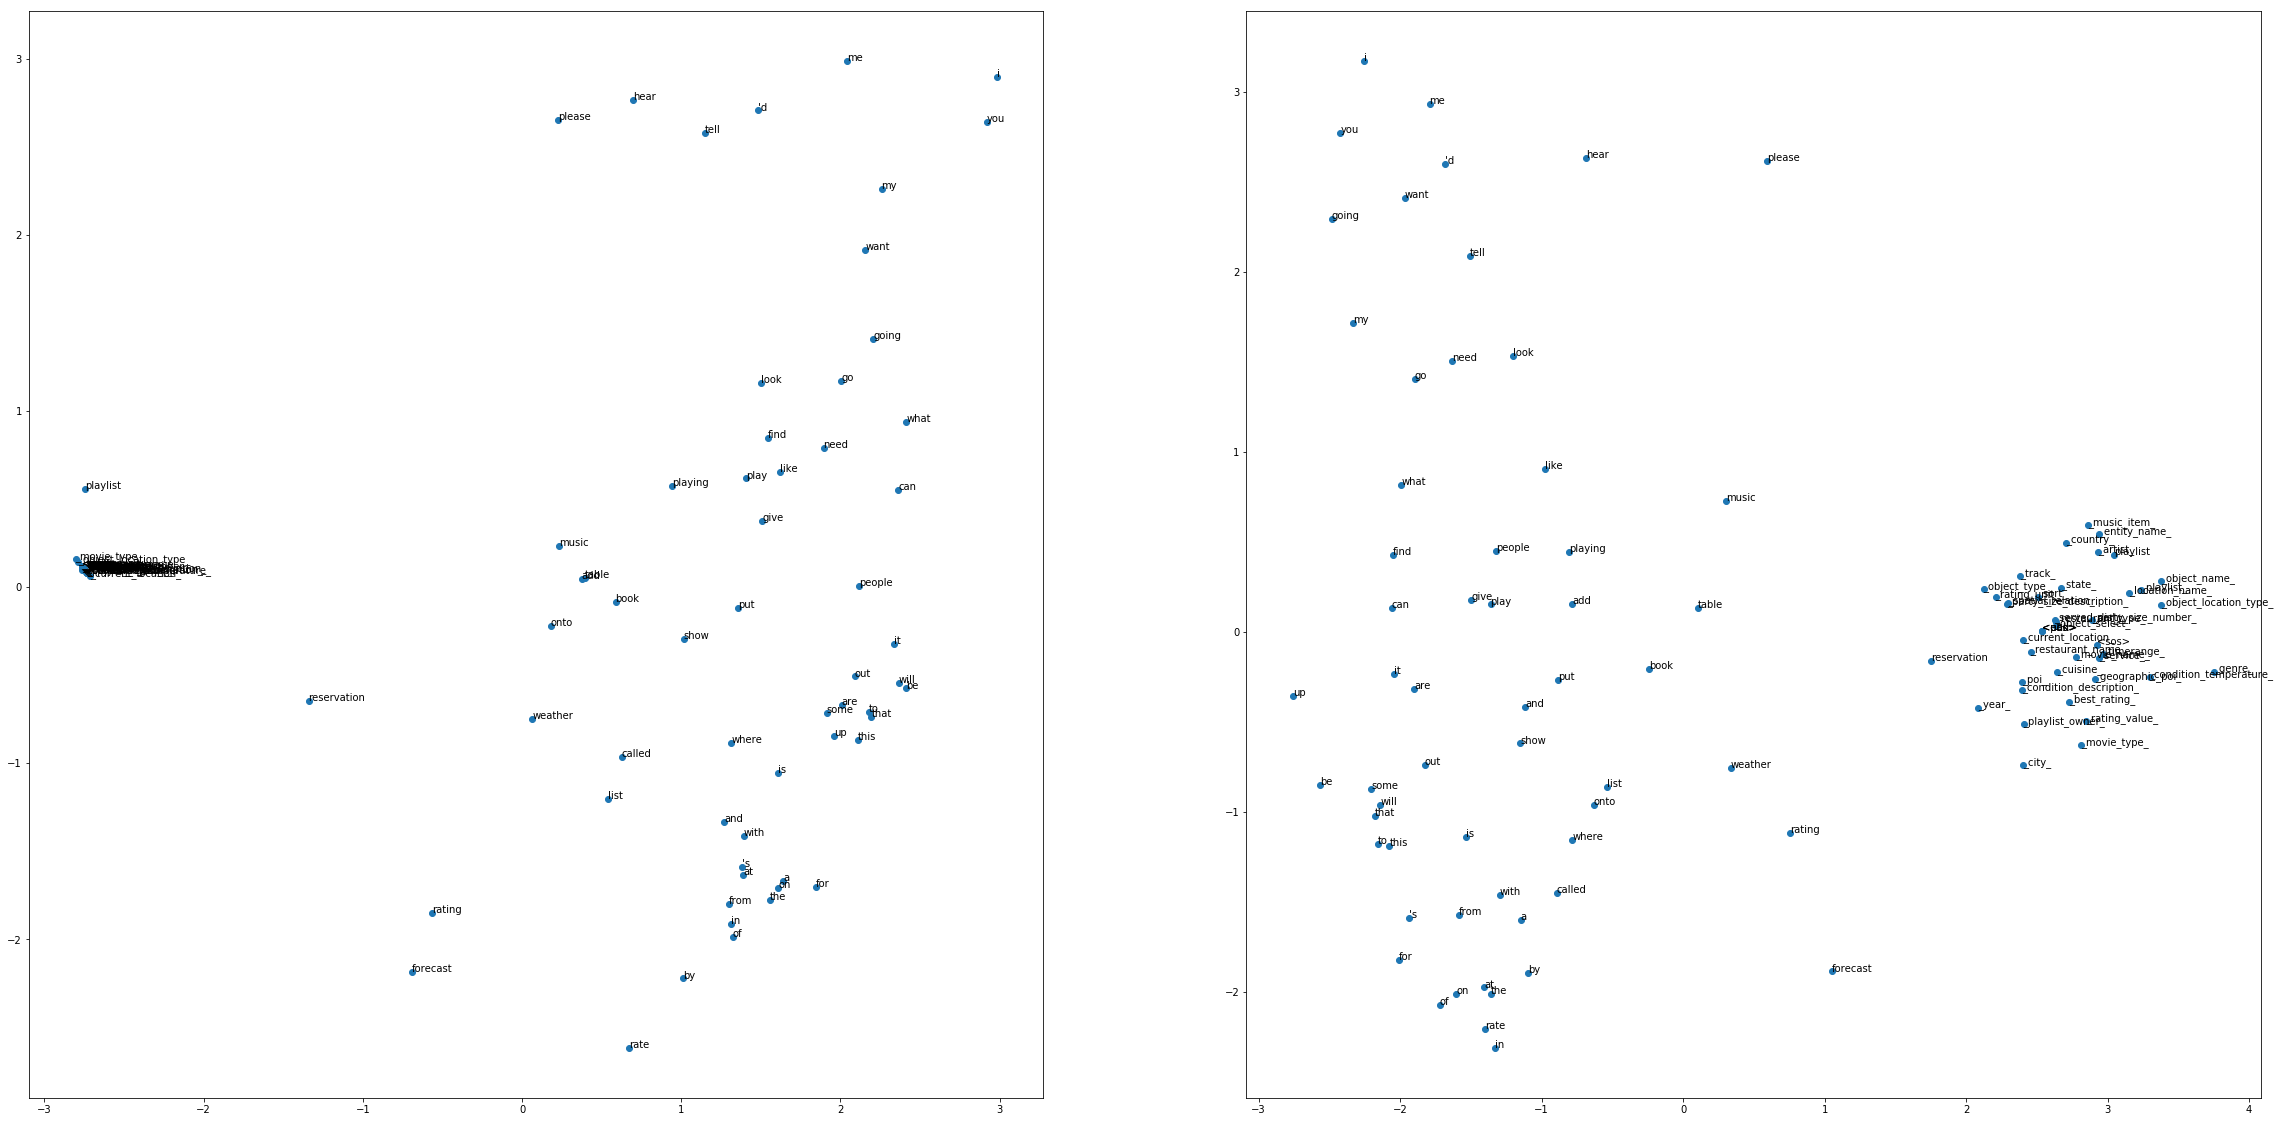

In [408]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(1, 2, figsize=(40,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors.cpu())
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]))

## Trajectories in latent space

In [209]:
!. ./venv/bin/activate

In [458]:
from models.embedding import Datasets
from models.cvae import CVAE
from utils.utils import to_device, interpolate, idx2word

run = torch.load('run.pkl')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature,
        conditional=False if args.conditional=='none' else True,
        bow=args.bow_loss
    )

state_dict = torch.load(args.pickle+'.pyT')
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

ModuleNotFoundError: No module named 'automatic_data_generation'

In [63]:
i2int

['GetWeather',
 'PlayMusic',
 'BookRestaurant',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork',
 'AddToPlaylist']

### Vary the continuous variable

In [463]:
for i, intent in enumerate(i2int):
    
    interp_dim = 1
    print(intent)

    #z1 = torch.randn([args.latent_size]).numpy()
    #z2 = torch.randn([args.latent_size]).numpy()
    z1 = torch.zeros([args.latent_size]).numpy()
    z2 = torch.zeros([args.latent_size]).numpy()
    z1[interp_dim] = -5
    z2[interp_dim] = +5
    z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
    batch_size=z.size(0)

    y_onehot = torch.zeros(batch_size, model.n_classes)
    y = torch.LongTensor(batch_size,1).fill_(i)
    y_onehot.scatter_(1, y, 1)
    samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

    print('-------INTERPOLATIONS-------')
    print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
    print('\n')

NameError: name 'i2int' is not defined

### Vary the discrete variable

z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

In [461]:
import torch
import numpy as np
target = torch.arange(0,5*64).view(64,-1)
bow = torch.randn((64,500))

loss = 0
for b, t in zip(bow, target):
    loss += torch.sum(b[t])
print(loss)
x = bow[:,target].view(64,64,)
print(x.size())
print(torch.einsum('iik->',(x)))
    #print(np.sum([b[idx].numpy() for idx in t]))

tensor(-1.1742)


RuntimeError: shape '[64, 64]' is invalid for input of size 20480

# Grid search

In [487]:
#results_dir = 'results_datasize_prop'
results_dir = 'results_gs_tiny'

In [488]:
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))

In [489]:
data = {}
for arg_name in runs[0]['args'].__dict__.keys():
    data[arg_name] = [getattr(run['args'], arg_name) for run in runs]
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy'] for run in runs])
data['raw']            = np.array([run['metrics']['improvement']['raw_acc'] for run in runs])
data['aug']            = np.array([run['metrics']['improvement']['aug_acc'] for run in runs])

data['metric'] = data['bleu_quality'] * data['bleu_diversity'] * data['accuracy']

df = pd.DataFrame(data, columns=['datasize', 'epochs', 'x1', 'x2', 'k1', 'k2', 
                                 'latent_size', 'hidden_size', 'num_layers', 'embedding_dropout', 'emb_dim', 'learning_rate', 'temperature',
                                 'bleu_quality', 'bleu_diversity', 'accuracy', 'raw', 'aug', 'metric'])
df = df.sort_values(by = 'metric', ascending=False)
df

,datasize,epochs,x1,x2,k1,k2,latent_size,hidden_size,num_layers,embedding_dropout,emb_dim,learning_rate,temperature,bleu_quality,bleu_diversity,accuracy,raw,aug,metric
45,300,10,100,100,0.01,0.010,8,512,1,0.75,200,0.01,1.0,0.864846,0.069110,0.976667,0.968571,0.950000,0.058375
123,300,10,100,100,0.01,0.001,8,256,1,0.25,200,0.01,0.5,0.921571,0.048709,0.990000,0.962857,0.950000,0.044439
80,300,10,100,100,0.01,0.010,8,512,1,0.25,200,0.01,1.0,0.892525,0.049418,0.990000,0.960000,0.960000,0.043666
49,300,10,100,100,0.01,0.010,8,512,1,0.75,100,0.01,0.5,0.885684,0.049533,0.986667,0.955714,0.948571,0.043285
83,300,10,100,100,0.01,0.010,8,512,1,0.25,50,0.01,1.0,0.909060,0.046663,1.000000,0.971429,0.955714,0.042420
54,300,10,100,100,0.01,0.010,8,512,1,0.25,200,0.01,0.5,0.877746,0.048694,0.956667,0.957143,0.951429,0.040889
106,300,10,100,100,0.01,0.010,8,512,1,0.25,100,0.01,1.0,0.860617,0.047964,0.990000,0.960000,0.944286,0.040866
89,300,10,100,100,0.01,0.010,8,512,1,0.75,200,0.01,0.5,0.885117,0.046511,0.976667,0.960000,0.950000,0.040207
18,300,10,100,100,0.01,0.010,8,512,1,0.50,200,0.01,0.5,0.876106,0.047273,0.956667,0.961429,0.935714,0.039621
3,300,10,100,100,0.01,0.010,8,256,1,0.50,200,0.01,0.5,0.922370,0.041632,1.000000,0.961429,0.958571,0.038400


In [510]:
irun = np.argmax(data['metric'])
print(irun)
run = runs[irun]
list(zip(run['generated']['intents'], runs[irun]['generated']['utterances']))[:100]

45


[('GetWeather',
  'will it cloudy  not  austin creek state recreation area  on now  '),
 ('RateBook', 'i give things fall apart  2  out of 6  stars  '),
 ('BookRestaurant',
  'book a table for eight  people at a bar  that serves souvlaki  for today  '),
 ('BookRestaurant',
  'book a spot for nine  at a bar  that serves ice cream cake  for feb the second  '),
 ('RateBook', 'rate baby-sittor  2  out of 6  stars  '),
 ('SearchScreeningEvent',
  'find the show  for holiday heart  at a movie theatre  '),
 ('SearchCreativeWork', 'i want to play the album  the gill deacon show  '),
 ('PlayMusic', 'play me a 1982  arif  '),
 ('GetWeather',
  'tell me the weather forecast for my current position  on in twenty three minutes  '),
 ('RateBook', 'give 3  point to current  book  '),
 ('SearchScreeningEvent',
  'find the times  for the honeymoon killers  at a cinema  '),
 ('SearchScreeningEvent',
  'what time is kate y leopold  showing at the movie house  '),
 ('RateBook', 'rate why orwell matters  3

No handles with labels found to put in legend.


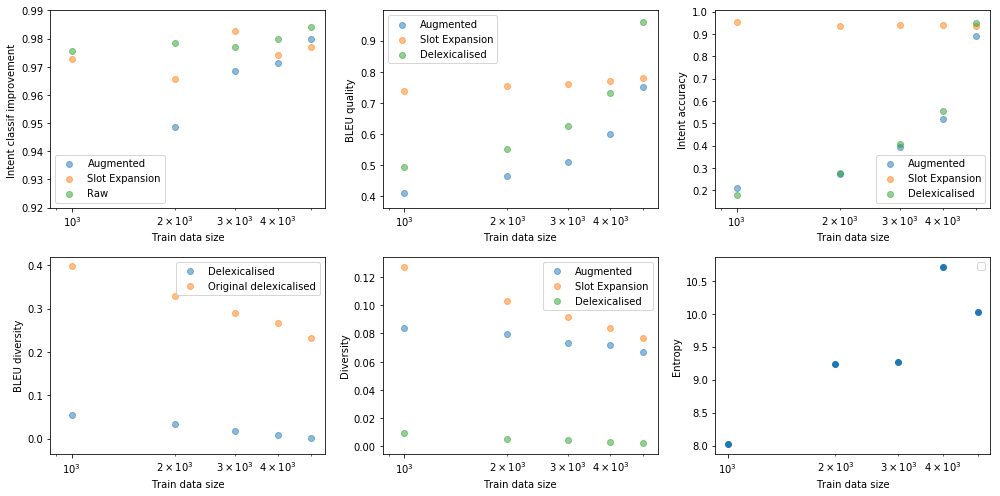

In [382]:
datasizes        = [run['args'].datasize for run in runs]
bleu_qualities   = [run['metrics']['bleu_scores']['quality']['avg'] for run in runs]
bleu_diversities = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
diversities      = [run['metrics']['diversity'] for run in runs]
entropies     = [run['metrics']['entropy'] for run in runs]
accuracies       = [run['metrics']['intent_accuracy'] for run in runs]
raw          = [run['metrics']['improvement']['raw_acc'] for run in runs]
augmented    = [run['metrics']['improvement']['aug_acc'] for run in runs]
se_augmented = [run['slot_expansion_metrics']['improvement']['aug_acc'] for run in runs]

delex_bleu_qualities   = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
delex_bleu_diversities = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_delex_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
delex_diversities      = [run['delexicalised_metrics']['diversity'] for run in runs]
delex_accuracies       = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]

se_bleu_qualities   = [run['slot_expansion_metrics']['bleu_scores']['quality']['avg'] for run in runs]
se_bleu_diversities = [run['slot_expansion_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
se_diversities      = [run['slot_expansion_metrics']['diversity'] for run in runs]
se_accuracies       = [run['slot_expansion_metrics']['intent_accuracy'] for run in runs]

fig, axarr = plt.subplots(2,3, figsize=(14,7))
axarr = axarr.flatten()

axarr[0].scatter(datasizes, augmented, label='Augmented'                ,alpha=0.5)
axarr[0].scatter(datasizes, se_augmented, label='Slot Expansion'        ,alpha=0.5)
axarr[0].scatter(datasizes, raw, label='Raw'                            ,alpha=0.5)
axarr[1].scatter(datasizes, bleu_qualities     ,label='Augmented'     ,alpha=0.5)
axarr[1].scatter(datasizes, se_bleu_qualities  ,label='Slot Expansion'  ,alpha=0.5)
axarr[1].scatter(datasizes, delex_bleu_qualities  ,label='Delexicalised',alpha=0.5)
axarr[2].scatter(datasizes, accuracies         ,label='Augmented'     ,alpha=0.5)
axarr[2].scatter(datasizes, se_accuracies      ,label='Slot Expansion'  ,alpha=0.5)
axarr[2].scatter(datasizes, delex_accuracies      ,label='Delexicalised',alpha=0.5)
#axarr[3].scatter(datasizes, org_bleu_diversities,label='Original',alpha=0.5)
#axarr[3].scatter(datasizes, bleu_diversities   ,label='Augmented'     ,alpha=0.5)
#axarr[3].scatter(datasizes, se_bleu_diversities,label='Slot Expansion'  ,alpha=0.5)
axarr[3].scatter(datasizes, delex_bleu_diversities,label='Delexicalised',alpha=0.5)
axarr[3].scatter(datasizes, org_delex_bleu_diversities,label='Original delexicalised',alpha=0.5)
axarr[4].scatter(datasizes, diversities        ,label='Augmented'     ,alpha=0.5)
axarr[4].scatter(datasizes, se_diversities     ,label='Slot Expansion'  ,alpha=0.5)
axarr[4].scatter(datasizes, delex_diversities     ,label='Delexicalised',alpha=0.5)
axarr[5].scatter(datasizes, entropies                                   )

axarr[0].set_ylabel('Intent classif improvement ')
axarr[1].set_ylabel('BLEU quality')
axarr[2].set_ylabel('Intent accuracy')
axarr[3].set_ylabel('BLEU diversity')
axarr[4].set_ylabel('Diversity')
axarr[5].set_ylabel('Entropy')
for ax in axarr:
    ax.set_xscale('log')
    ax.set_xlabel('Train data size')
    ax.legend()
axarr[0].set_ylim(0.92,0.99)
fig.tight_layout()

In [508]:
def demo():
    
    run = torch.load('run.pkl')

    requested_intent = input('Select your intent : ')
    print('\n')
    indices = [i for i,intent in enumerate(run['generated']['intents']) if intent == requested_intent]

    print(*[run['generated']['utterances'][idx] for idx in indices], sep='\n\n')

In [523]:
demo()

Select your intent :  GetWeather




what is the rain  forecast for rogers city  at sep 21 2034  

what is the forecast for october 9  at big walnut creek nature preserve  

what is the hotter  in fort mckinley  and south africa  at may the twenty-seventh  

what is the temperate  forecast for aug the nineteenth  at antelope island  

what is the storm  forecast for nov the 1st  in vietnam  

weather on in 8 hours  in west whittier  vietnam  

will it be chillier  in choptank  

will it be temperate  in seattle heights  

what 's the weather going to be like in south sudan  mar the twenty-eighth  

will it be nice on breakfast  in grand portage  vietnam  

is it cloudy  season in sinclair  

what is the rainfall  forecast for mar the twenty-eighth  in saint pierre and miquelon  

tell me the forecast for roseau  maine  

will it be nice by choice  to the weather going to be like current position  at 1 hour from now  

what is the forecast for four minutes from now  in tx  

what is the forecast for twenty three minutes 